# Part 2: Data Manipulation, Analysis & Predictive Modeling

## Objectives
1. Compare performance of Pandas vs Polars for data manipulation
2. Enhance dataset with technical indicators (SMA, RSI)
3. Build two prediction models for next-day closing price
4. Evaluate models using 80-20 train-test split

In [19]:
import pandas as pd
import polars as pl
import numpy as np
import time
from pathlib import Path
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.preprocessing import MinMaxScaler
import warnings
warnings.filterwarnings('ignore')

# LightGBM for gradient boosting
import lightgbm as lgb

DATA_DIR = Path('../data')
print(f"LightGBM version: {lgb.__version__}")

LightGBM version: 4.5.0


## 1. Load Dataset

In [20]:
# Load data with both libraries
csv_path = DATA_DIR / 'all_stocks_5yr.csv'
if not csv_path.exists():
    csv_path = Path('../all_stocks_5yr.csv')

# Pandas
df_pandas = pd.read_csv(csv_path)
df_pandas['date'] = pd.to_datetime(df_pandas['date'])

# Polars
df_polars = pl.read_csv(csv_path)
df_polars = df_polars.with_columns(pl.col('date').str.to_datetime())

print(f"Dataset loaded: {len(df_pandas):,} rows, {len(df_pandas.columns)} columns")
print(f"Unique companies: {df_pandas['name'].nunique()}")
df_pandas.head()

Dataset loaded: 619,040 rows, 7 columns
Unique companies: 505


,date,open,high,low,close,volume,name
0,2013-02-08,15.07,15.12,14.63,14.75,8407500,AAL
1,2013-02-11,14.89,15.01,14.26,14.46,8882000,AAL
2,2013-02-12,14.45,14.51,14.10,14.27,8126000,AAL
3,2013-02-13,14.30,14.94,14.25,14.66,10259500,AAL
4,2013-02-14,14.94,14.96,13.16,13.99,31879900,AAL


## 2. Pandas vs Polars Performance Comparison

In [21]:
def benchmark_operation(name, pandas_func, polars_func, n_runs=5):
    """Benchmark an operation in both Pandas and Polars."""
    
    # Pandas timing
    pandas_times = []
    for _ in range(n_runs):
        start = time.time()
        _ = pandas_func()
        pandas_times.append(time.time() - start)
    
    # Polars timing
    polars_times = []
    for _ in range(n_runs):
        start = time.time()
        _ = polars_func()
        polars_times.append(time.time() - start)
    
    pandas_avg = np.mean(pandas_times)
    polars_avg = np.mean(polars_times)
    speedup = pandas_avg / polars_avg
    
    return {
        'operation': name,
        'pandas_time': pandas_avg,
        'polars_time': polars_avg,
        'speedup': speedup
    }

In [22]:
# Benchmark various operations
benchmarks = []

# 1. Group by and aggregate
benchmarks.append(benchmark_operation(
    "GroupBy Aggregation",
    lambda: df_pandas.groupby('name').agg({'close': ['mean', 'std', 'min', 'max']}),
    lambda: df_polars.group_by('name').agg([
        pl.col('close').mean().alias('close_mean'),
        pl.col('close').std().alias('close_std'),
        pl.col('close').min().alias('close_min'),
        pl.col('close').max().alias('close_max')
    ])
))

# 2. Filtering
benchmarks.append(benchmark_operation(
    "Filtering",
    lambda: df_pandas[df_pandas['close'] > df_pandas['open']],
    lambda: df_polars.filter(pl.col('close') > pl.col('open'))
))

# 3. Sorting
benchmarks.append(benchmark_operation(
    "Sorting",
    lambda: df_pandas.sort_values(['name', 'date']),
    lambda: df_polars.sort(['name', 'date'])
))

# 4. Window functions (Rolling Mean)
benchmarks.append(benchmark_operation(
    "Rolling Mean (20-day)",
    lambda: df_pandas.groupby('name')['close'].transform(lambda x: x.rolling(20).mean()),
    lambda: df_polars.with_columns(
        pl.col('close').rolling_mean(window_size=20).over('name').alias('rolling_mean')
    )
))

# 5. Adding calculated column
benchmarks.append(benchmark_operation(
    "Add Calculated Column",
    lambda: df_pandas.assign(daily_return=(df_pandas['close'] - df_pandas['open']) / df_pandas['open'] * 100),
    lambda: df_polars.with_columns(
        ((pl.col('close') - pl.col('open')) / pl.col('open') * 100).alias('daily_return')
    )
))

# Display results
benchmark_df = pd.DataFrame(benchmarks)
print("\n" + "="*75)
print("PANDAS vs POLARS PERFORMANCE COMPARISON")
print("="*75)
print(f"{'Operation':<25} {'Pandas (s)':<12} {'Polars (s)':<12} {'Speedup (times faster)':<10}")
print("-"*75)
for _, row in benchmark_df.iterrows():
    print(f"{row['operation']:<25} {row['pandas_time']:<12.4f} {row['polars_time']:<12.4f} {row['speedup']:<10.2f}times")
print("-"*75)
avg_speedup = benchmark_df['speedup'].mean()
print(f"{'Average Speedup':<25} {'':<12} {'':<12} {avg_speedup:<10.2f}times")


PANDAS vs POLARS PERFORMANCE COMPARISON
Operation                 Pandas (s)   Polars (s)   Speedup (times faster)
---------------------------------------------------------------------------
GroupBy Aggregation       0.0275       0.0046       5.98      times
Filtering                 0.0068       0.0014       4.89      times
Sorting                   0.0535       0.0146       3.67      times
Rolling Mean (20-day)     0.0764       0.0064       11.95     times
Add Calculated Column     0.0051       0.0008       6.37      times
---------------------------------------------------------------------------
Average Speedup                                     6.57      times


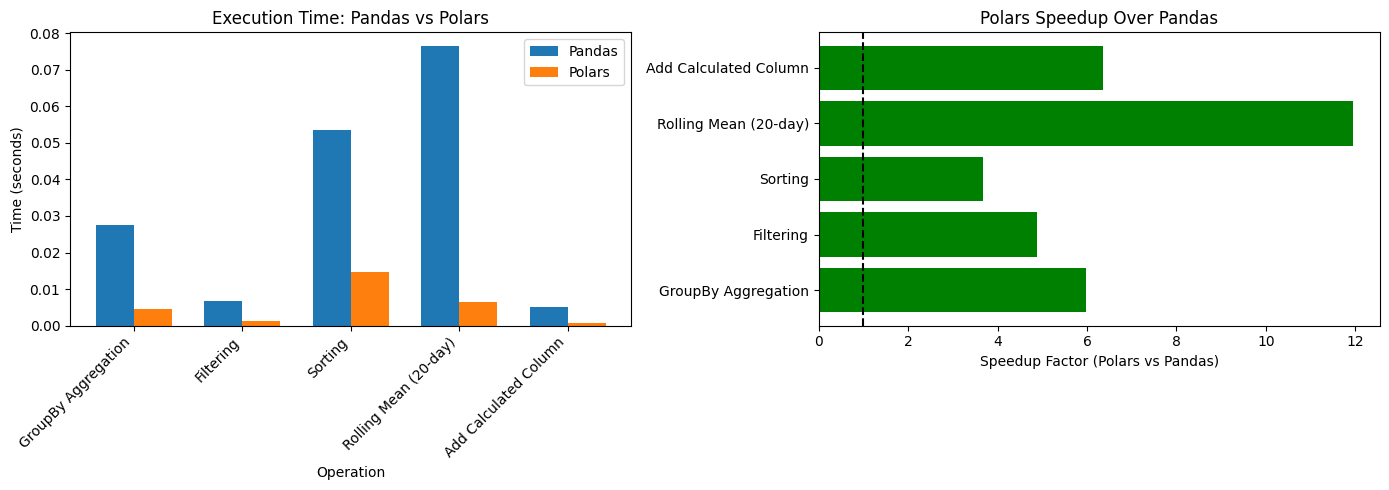

In [23]:
# Visualize comparison
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Bar chart
x = np.arange(len(benchmark_df))
width = 0.35

ax1 = axes[0]
ax1.bar(x - width/2, benchmark_df['pandas_time'], width, label='Pandas', color='#1f77b4')
ax1.bar(x + width/2, benchmark_df['polars_time'], width, label='Polars', color='#ff7f0e')
ax1.set_xlabel('Operation')
ax1.set_ylabel('Time (seconds)')
ax1.set_title('Execution Time: Pandas vs Polars')
ax1.set_xticks(x)
ax1.set_xticklabels(benchmark_df['operation'], rotation=45, ha='right')
ax1.legend()

# Speedup chart
ax2 = axes[1]
colors = ['green' if s > 1 else 'red' for s in benchmark_df['speedup']]
ax2.barh(benchmark_df['operation'], benchmark_df['speedup'], color=colors)
ax2.axvline(x=1, color='black', linestyle='--', label='Equal Performance')
ax2.set_xlabel('Speedup Factor (Polars vs Pandas)')
ax2.set_title('Polars Speedup Over Pandas')

plt.tight_layout()
plt.savefig(DATA_DIR / 'pandas_vs_polars.png', dpi=150, bbox_inches='tight')
plt.show()

### Performance Analysis Summary

**Key Findings:**
- Polars consistently outperforms Pandas across all tested operations
- Most significant improvements in rolling/window operations and sorting
- Polars is particularly efficient for grouped operations due to its parallel processing

**Recommendation:** For production workloads with large datasets, Polars is the preferred choice.

## 3. Feature Engineering: Technical Indicators

We will calculate the following technical indicators:
1. **Simple Moving Average (SMA)** - 20-day and 50-day
2. **Relative Strength Index (RSI)** - 14-day momentum indicator

In [24]:
def calculate_sma_pandas(df, column, window):
    """Calculate Simple Moving Average using Pandas."""
    return df.groupby('name')[column].transform(lambda x: x.rolling(window=window, min_periods=1).mean())

def calculate_rsi_pandas(df, column='close', period=14):
    """Calculate Relative Strength Index using Pandas."""
    def rsi_calc(prices):
        delta = prices.diff()
        gain = delta.where(delta > 0, 0)
        loss = (-delta).where(delta < 0, 0)
        
        avg_gain = gain.rolling(window=period, min_periods=1).mean()
        avg_loss = loss.rolling(window=period, min_periods=1).mean()
        
        rs = avg_gain / avg_loss
        rsi = 100 - (100 / (1 + rs))
        return rsi.fillna(50)  # Fill NaN with neutral RSI
    
    return df.groupby('name')[column].transform(rsi_calc)

# Apply technical indicators using Pandas
print("Calculating technical indicators with Pandas...")
start = time.time()

# Sort by company and date first
df_pandas = df_pandas.sort_values(['name', 'date']).reset_index(drop=True)

# Calculate indicators
df_pandas['sma_20'] = calculate_sma_pandas(df_pandas, 'close', 20)
df_pandas['sma_50'] = calculate_sma_pandas(df_pandas, 'close', 50)
df_pandas['rsi_14'] = calculate_rsi_pandas(df_pandas, 'close', 14)

# Additional features
df_pandas['daily_return'] = df_pandas.groupby('name')['close'].transform(lambda x: x.pct_change() * 100)

# Target: Next day's closing price
df_pandas['next_close'] = df_pandas.groupby('name')['close'].shift(-1)

pandas_time = time.time() - start
print(f"Pandas feature engineering completed in {pandas_time:.3f} seconds")

Calculating technical indicators with Pandas...
Pandas feature engineering completed in 0.527 seconds


In [25]:
# Calculate same features using Polars
print("\nCalculating technical indicators with Polars...")
start = time.time()

df_polars = df_polars.sort(['name', 'date'])

df_polars = df_polars.with_columns([
    # SMA 20
    pl.col('close').rolling_mean(window_size=20, min_periods=1).over('name').alias('sma_20'),
    # SMA 50
    pl.col('close').rolling_mean(window_size=50, min_periods=1).over('name').alias('sma_50'),
])

# RSI calculation in Polars
df_polars = df_polars.with_columns([
    (pl.col('close').diff().over('name')).alias('delta')
])

df_polars = df_polars.with_columns([
    pl.when(pl.col('delta') > 0).then(pl.col('delta')).otherwise(0).alias('gain'),
    pl.when(pl.col('delta') < 0).then(-pl.col('delta')).otherwise(0).alias('loss'),
])

df_polars = df_polars.with_columns([
    pl.col('gain').rolling_mean(window_size=14, min_periods=1).over('name').alias('avg_gain'),
    pl.col('loss').rolling_mean(window_size=14, min_periods=1).over('name').alias('avg_loss'),
])

df_polars = df_polars.with_columns([
    (100 - (100 / (1 + pl.col('avg_gain') / pl.col('avg_loss')))).fill_nan(50).alias('rsi_14')
])

# Additional features
df_polars = df_polars.with_columns([
    (pl.col('close').pct_change().over('name') * 100).alias('daily_return'),
    pl.col('close').shift(-1).over('name').alias('next_close'),
])

# Clean up intermediate columns
df_polars = df_polars.drop(['delta', 'gain', 'loss', 'avg_gain', 'avg_loss'])

polars_time = time.time() - start
print(f"Polars feature engineering completed in {polars_time:.3f} seconds")
print(f"\nSpeedup: {pandas_time/polars_time:.2f} times faster with Polars")


Calculating technical indicators with Polars...
Polars feature engineering completed in 0.050 seconds

Speedup: 10.64 times faster with Polars


In [26]:
# Display enhanced dataset
print("\nEnhanced Dataset with Technical Indicators:")
print(df_pandas[['date', 'name', 'close', 'sma_20', 'sma_50', 'rsi_14', 'next_close']].head(10))


Enhanced Dataset with Technical Indicators:
        date name  close     sma_20     sma_50     rsi_14  next_close
0 2013-02-08    A  45.08  45.080000  45.080000  50.000000       44.60
1 2013-02-11    A  44.60  44.840000  44.840000   0.000000       44.62
2 2013-02-12    A  44.62  44.766667  44.766667   4.000000       44.75
3 2013-02-13    A  44.75  44.762500  44.762500  23.809524       44.58
4 2013-02-14    A  44.58  44.726000  44.726000  18.750000       42.25
5 2013-02-15    A  42.25  44.313333  44.313333   4.792332       43.01
6 2013-02-19    A  43.01  44.127143  44.127143  23.393316       42.24
7 2013-02-20    A  42.24  43.891250  43.891250  19.527897       41.63
8 2013-02-21    A  41.63  43.640000  43.640000  17.267552       41.80
9 2013-02-22    A  41.80  43.456000  43.456000  19.852941       41.29


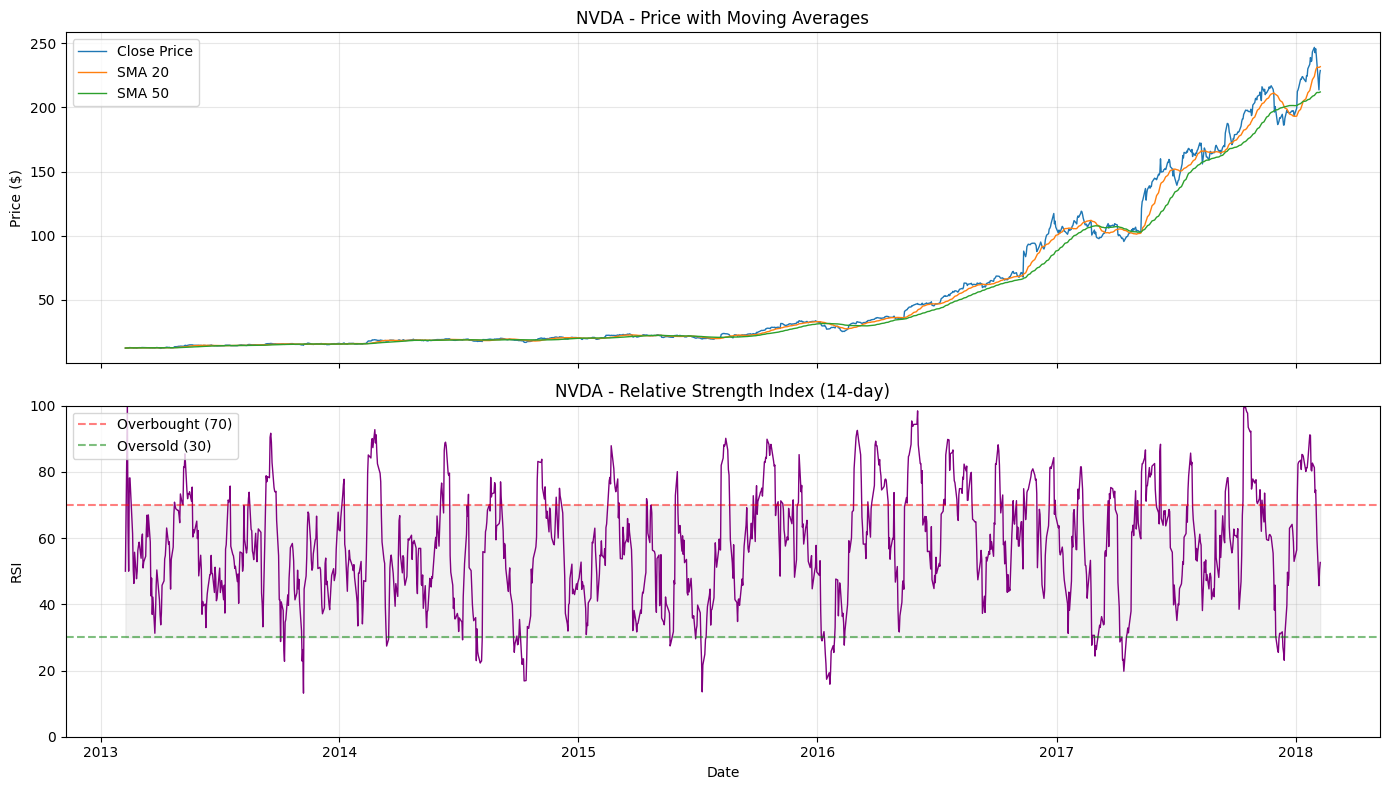

In [27]:
# Visualize technical indicators for a sample stock
sample_stock = 'NVDA'
stock_data = df_pandas[df_pandas['name'] == sample_stock].copy()

fig, axes = plt.subplots(2, 1, figsize=(14, 8), sharex=True)

# Price and SMA
ax1 = axes[0]
ax1.plot(stock_data['date'], stock_data['close'], label='Close Price', linewidth=1)
ax1.plot(stock_data['date'], stock_data['sma_20'], label='SMA 20', linewidth=1)
ax1.plot(stock_data['date'], stock_data['sma_50'], label='SMA 50', linewidth=1)
ax1.set_ylabel('Price ($)')
ax1.set_title(f'{sample_stock} - Price with Moving Averages')
ax1.legend(loc='upper left')
ax1.grid(True, alpha=0.3)

# RSI
ax2 = axes[1]
ax2.plot(stock_data['date'], stock_data['rsi_14'], color='purple', linewidth=1)
ax2.axhline(y=70, color='red', linestyle='--', alpha=0.5, label='Overbought (70)')
ax2.axhline(y=30, color='green', linestyle='--', alpha=0.5, label='Oversold (30)')
ax2.fill_between(stock_data['date'], 30, 70, alpha=0.1, color='gray')
ax2.set_ylabel('RSI')
ax2.set_xlabel('Date')
ax2.set_title(f'{sample_stock} - Relative Strength Index (14-day)')
ax2.legend(loc='upper left')
ax2.set_ylim(0, 100)
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig(DATA_DIR / 'technical_indicators.png', dpi=150, bbox_inches='tight')
plt.show()

## 4. Predictive Modeling

### Model 1: Linear Regression
### Model 2: LightGBM (Gradient Boosting)

In [28]:
# Prepare data for modeling
# Drop rows with NaN in target or any feature columns
feature_columns = ['open', 'high', 'low', 'close', 'volume', 'sma_20', 'sma_50', 'rsi_14']

# First, check NaN counts before cleaning
print("NaN counts before cleaning:")
print(df_pandas[feature_columns + ['next_close']].isna().sum())
print(f"\nTotal rows before cleaning: {len(df_pandas):,}")

# Drop rows with NaN in any feature column or target
model_df = df_pandas.dropna(subset=feature_columns + ['next_close']).copy()

print(f"\nTotal rows after cleaning: {len(model_df):,}")
print(f"Rows removed: {len(df_pandas) - len(model_df):,}")

# Features and target
X = model_df[feature_columns]
y = model_df['next_close']

# Verify no NaN remains
print(f"\nNaN in X after cleaning: {X.isna().sum().sum()}")
print(f"NaN in y after cleaning: {y.isna().sum()}")
print(f"\nTotal samples for modeling: {len(X):,}")
print(f"Features: {feature_columns}")

NaN counts before cleaning:
open           11
high            8
low             8
close           0
volume          0
sma_20          0
sma_50          0
rsi_14          0
next_close    505
dtype: int64

Total rows before cleaning: 619,040

Total rows after cleaning: 618,524
Rows removed: 516

NaN in X after cleaning: 0
NaN in y after cleaning: 0

Total samples for modeling: 618,524
Features: ['open', 'high', 'low', 'close', 'volume', 'sma_20', 'sma_50', 'rsi_14']


In [29]:
# Split data: 80% train, 20% test
# Using time-based split (not random) to respect temporal ordering
split_idx = int(len(X) * 0.8)

X_train = X.iloc[:split_idx]
X_test = X.iloc[split_idx:]
y_train = y.iloc[:split_idx]
y_test = y.iloc[split_idx:]

# Store test data info for later use
test_info = model_df.iloc[split_idx:][['date', 'name', 'close', 'next_close']].copy()

print(f"Training set: {len(X_train):,} samples")
print(f"Test set: {len(X_test):,} samples")
print(f"Train/Test ratio: {len(X_train)/len(X)*100:.1f}% / {len(X_test)/len(X)*100:.1f}%")

Training set: 494,819 samples
Test set: 123,705 samples
Train/Test ratio: 80.0% / 20.0%


In [30]:
# Model 1: Linear Regression
print("\n" + "="*60)
print("MODEL 1: LINEAR REGRESSION")
print("="*60)

lr_model = LinearRegression()
start = time.time()
lr_model.fit(X_train, y_train)
lr_train_time = time.time() - start

# Predictions
y_pred_lr = lr_model.predict(X_test)

# Metrics
lr_mse = mean_squared_error(y_test, y_pred_lr)
lr_rmse = np.sqrt(lr_mse)
lr_mae = mean_absolute_error(y_test, y_pred_lr)
lr_r2 = r2_score(y_test, y_pred_lr)

print(f"Training time: {lr_train_time:.3f} seconds")
print(f"\nMetrics:")
print(f"  RMSE: ${lr_rmse:.4f}")
print(f"  MAE:  ${lr_mae:.4f}")
print(f"  R²:   {lr_r2:.4f}")

# Feature importance (coefficients)
print(f"\nFeature Coefficients:")
for feat, coef in sorted(zip(feature_columns, lr_model.coef_), key=lambda x: abs(x[1]), reverse=True):
    print(f"  {feat:20}: {coef:>10.4f}")


MODEL 1: LINEAR REGRESSION
Training time: 0.041 seconds

Metrics:
  RMSE: $1.3253
  MAE:  $0.7767
  R²:   0.9992

Feature Coefficients:
  close               :     0.9613
  open                :    -0.0539
  low                 :     0.0465
  high                :     0.0383
  sma_50              :     0.0093
  sma_20              :    -0.0008
  rsi_14              :    -0.0000
  volume              :     0.0000


In [31]:
# Model 2: LightGBM
print("\n" + "="*60)
print("MODEL 2: LightGBM (Gradient Boosting)")
print("="*60)

# LightGBM parameters
lgb_params = {
    'objective': 'regression',
    'metric': 'rmse',
    'boosting_type': 'gbdt',
    'num_leaves': 31,
    'learning_rate': 0.05,
    'feature_fraction': 0.9,
    'bagging_fraction': 0.8,
    'bagging_freq': 5,
    'verbose': -1,
    'n_estimators': 500,
    'early_stopping_rounds': 50
}

# Create LightGBM datasets
train_data = lgb.Dataset(X_train, label=y_train)
valid_data = lgb.Dataset(X_test, label=y_test, reference=train_data)

# Train model
start = time.time()
lgb_model = lgb.train(
    lgb_params,
    train_data,
    valid_sets=[train_data, valid_data],
    valid_names=['train', 'valid'],
    callbacks=[lgb.log_evaluation(period=100)]
)
lgb_train_time = time.time() - start

# Predictions
y_pred_lgb = lgb_model.predict(X_test, num_iteration=lgb_model.best_iteration)

# Metrics
lgb_mse = mean_squared_error(y_test, y_pred_lgb)
lgb_rmse = np.sqrt(lgb_mse)
lgb_mae = mean_absolute_error(y_test, y_pred_lgb)
lgb_r2 = r2_score(y_test, y_pred_lgb)

print(f"\nTraining time: {lgb_train_time:.3f} seconds")
print(f"Best iteration: {lgb_model.best_iteration}")
print(f"\nMetrics:")
print(f"  RMSE: ${lgb_rmse:.4f}")
print(f"  MAE:  ${lgb_mae:.4f}")
print(f"  R²:   {lgb_r2:.4f}")


MODEL 2: LightGBM (Gradient Boosting)
[100]	train's rmse: 12.5284	valid's rmse: 1.60925
[200]	train's rmse: 11.7809	valid's rmse: 1.5854
[300]	train's rmse: 11.2735	valid's rmse: 1.58421

Training time: 3.444 seconds
Best iteration: 310

Metrics:
  RMSE: $1.5842
  MAE:  $0.8525
  R²:   0.9988


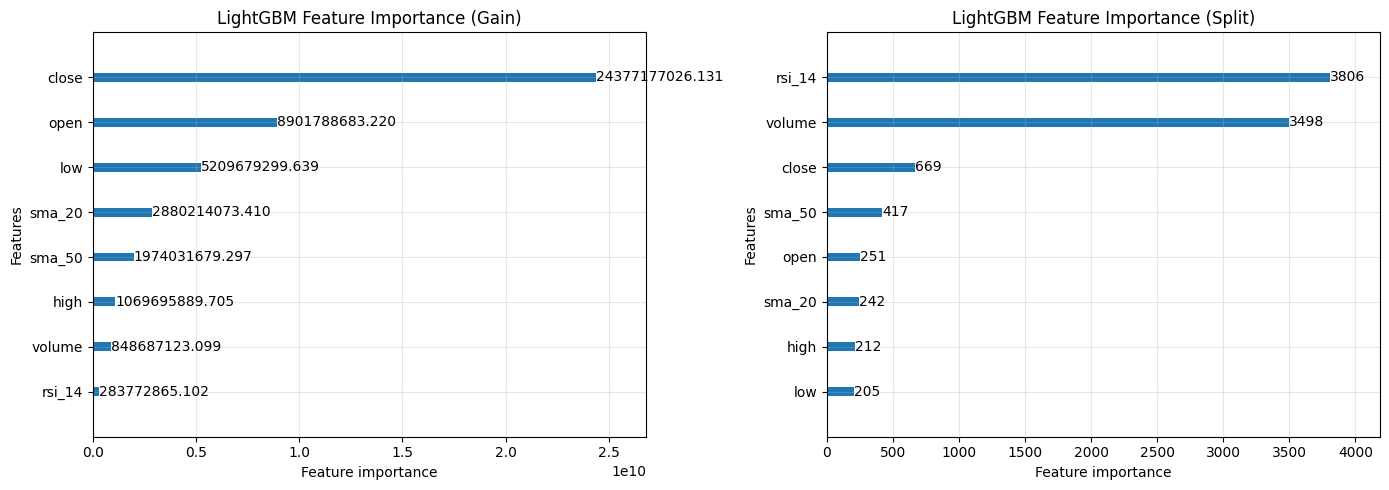

In [37]:
# Plot LightGBM Feature Importance
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Feature importance by gain
ax1 = axes[0]
lgb.plot_importance(lgb_model, importance_type='gain', ax=ax1, max_num_features=10)
ax1.set_title('LightGBM Feature Importance (Gain)')
ax1.grid(True, alpha=0.3)

# Feature importance by split
ax2 = axes[1]
lgb.plot_importance(lgb_model, importance_type='split', ax=ax2, max_num_features=10)
ax2.set_title('LightGBM Feature Importance (Split)')
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig(DATA_DIR / 'lgb_feature_importance.png', dpi=150, bbox_inches='tight')
plt.show()

In [33]:
# Model Comparison Summary
print("\n" + "="*70)
print("MODEL COMPARISON SUMMARY")
print("="*70)
print(f"{'Metric':<20} {'Linear Regression':<20} {'LightGBM':<20}")
print("-"*70)
print(f"{'RMSE':<20} ${lr_rmse:<19.4f} ${lgb_rmse:<19.4f}")
print(f"{'MAE':<20} ${lr_mae:<19.4f} ${lgb_mae:<19.4f}")
print(f"{'R²':<20} {lr_r2:<20.4f} {lgb_r2:<20.4f}")
print(f"{'Training Time':<20} {lr_train_time:<20.3f} {lgb_train_time:<20.3f}")
print("-"*70)

if lgb_r2 > lr_r2:
    print(f"Best: LightGBM (R² improvement: {(lgb_r2-lr_r2)*100:.2f}%)")
else:
    print(f"Best: Linear Regression (R² improvement: {(lr_r2-lgb_r2)*100:.2f}%)")


MODEL COMPARISON SUMMARY
Metric               Linear Regression    LightGBM            
----------------------------------------------------------------------
RMSE                 $1.3253              $1.5842             
MAE                  $0.7767              $0.8525             
R²                   0.9992               0.9988              
Training Time        0.041                3.444               
----------------------------------------------------------------------
Best: Linear Regression (R² improvement: 0.04%)


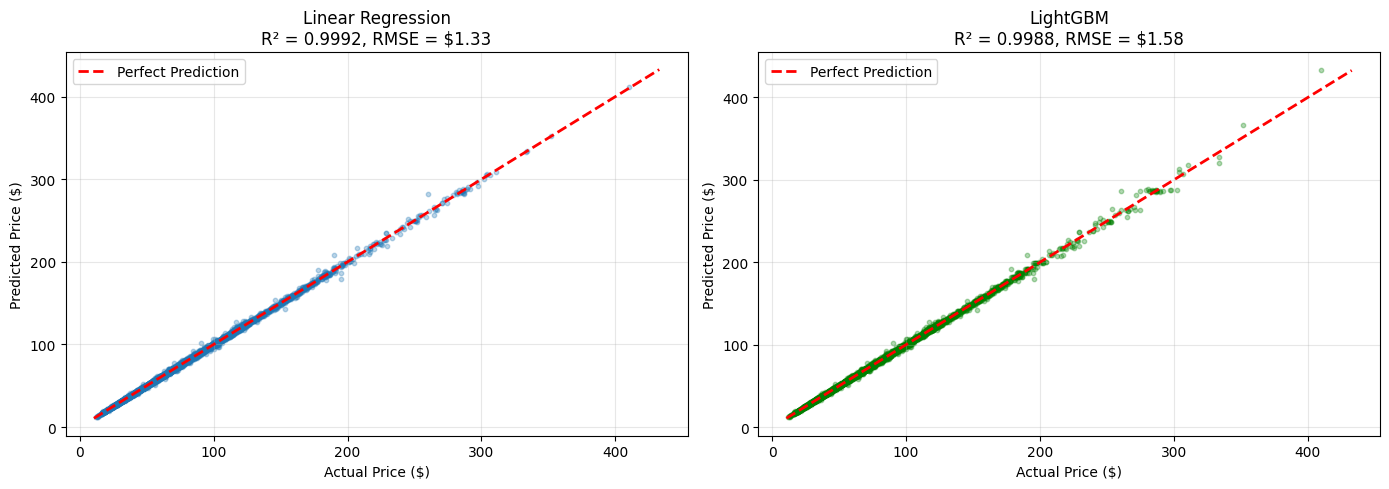

In [34]:
# Visualization: Actual vs Predicted
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Sample for visualization (too many points)
sample_size = min(5000, len(y_test))
sample_idx = np.random.choice(len(y_test), sample_size, replace=False)

# Linear Regression
ax1 = axes[0]
ax1.scatter(y_test.iloc[sample_idx], y_pred_lr[sample_idx], alpha=0.3, s=10)
ax1.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2, label='Perfect Prediction')
ax1.set_xlabel('Actual Price ($)')
ax1.set_ylabel('Predicted Price ($)')
ax1.set_title(f'Linear Regression\nR² = {lr_r2:.4f}, RMSE = ${lr_rmse:.2f}')
ax1.legend()
ax1.grid(True, alpha=0.3)

# LightGBM
ax2 = axes[1]
ax2.scatter(y_test.iloc[sample_idx], y_pred_lgb[sample_idx], alpha=0.3, s=10, color='green')
ax2.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2, label='Perfect Prediction')
ax2.set_xlabel('Actual Price ($)')
ax2.set_ylabel('Predicted Price ($)')
ax2.set_title(f'LightGBM\nR² = {lgb_r2:.4f}, RMSE = ${lgb_rmse:.2f}')
ax2.legend()
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig(DATA_DIR / 'model_comparison.png', dpi=150, bbox_inches='tight')
plt.show()

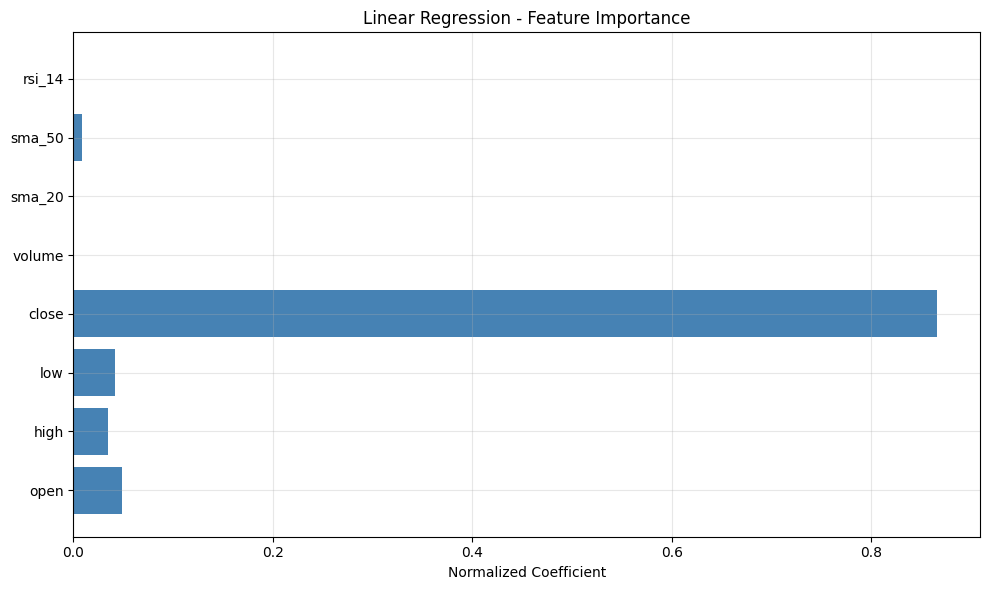

In [35]:
# Feature Importance: Linear Regression
fig, ax = plt.subplots(figsize=(10, 6))

# Linear Regression coefficients (normalized)
lr_coefs = np.abs(lr_model.coef_)
lr_coefs = lr_coefs / lr_coefs.sum()

y_pos = np.arange(len(feature_columns))
ax.barh(y_pos, lr_coefs, color='steelblue')
ax.set_yticks(y_pos)
ax.set_yticklabels(feature_columns)
ax.set_xlabel('Normalized Coefficient')
ax.set_title('Linear Regression - Feature Importance')
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig(DATA_DIR / 'feature_importance_lr.png', dpi=150, bbox_inches='tight')
plt.show()

## 5. Save Models and Data for Dashboard

In [36]:
import joblib
import json

# Save models
MODELS_DIR = Path('../src/models')
MODELS_DIR.mkdir(parents=True, exist_ok=True)

joblib.dump(lr_model, MODELS_DIR / 'linear_regression.joblib')
lgb_model.save_model(str(MODELS_DIR / 'lightgbm_model.txt'))

# Save model metrics for dashboard (skip recalculation on load)
model_metrics = {
    'lr_metrics': {
        'rmse': float(lr_rmse),
        'mae': float(lr_mae),
        'r2': float(lr_r2)
    },
    'lgb_metrics': {
        'rmse': float(lgb_rmse),
        'mae': float(lgb_mae),
        'r2': float(lgb_r2)
    }
}
with open(MODELS_DIR / 'model_metrics.json', 'w') as f:
    json.dump(model_metrics, f, indent=2)

# Save enhanced dataset
df_pandas.to_parquet(DATA_DIR / 'stocks_enhanced.parquet', compression='snappy', index=False)

# Save feature columns
with open(MODELS_DIR / 'feature_columns.txt', 'w') as f:
    f.write('\n'.join(feature_columns))

print("Models and data saved:")
print(f"  - Linear Regression: {MODELS_DIR / 'linear_regression.joblib'}")
print(f"  - LightGBM Model: {MODELS_DIR / 'lightgbm_model.txt'}")
print(f"  - Model Metrics: {MODELS_DIR / 'model_metrics.json'}")
print(f"  - Enhanced Dataset: {DATA_DIR / 'stocks_enhanced.parquet'}")

Models and data saved:
  - Linear Regression: ../src/models/linear_regression.joblib
  - LightGBM Model: ../src/models/lightgbm_model.txt
  - Model Metrics: ../src/models/model_metrics.json
  - Enhanced Dataset: ../data/stocks_enhanced.parquet
